In [1]:
# TCC: APLICAÇÃO DE MACHINE LEARNING PARA APOSTAS ESPORTIVAS: uso de Regressão Logística,
#      SVM, Árvore de Decisão e Naive Bayes
#
# Aluno: João Henrique
# Orientadora: Renata Alcoforado

In [2]:
# Importando as bibliotecas

import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score , f1_score, precision_score, recall_score
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import  GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import scale
%matplotlib inline

In [3]:
# O arquivo utilizado foi uma compilação com dados baixados do site www.football-data.co.uk, que disponibiliza...
# ... informações de diversos campeonatos ao redor do mundo
# Por meio do Excel foram retirados os jogos em que estavam faltando dados de quaisquer variáveis de interesse...
# ...para o estudo


# Legenda das variáveis:

# Div = Divisão da Liga
# Date = Data do jogo
# HomeTeam = Time da casa
# AwayTeam = Time visitante
# FTR = Resultado do jogo (0 = empate, 1 = vitória do time da casa, 2 = vitória do time visitante)
# B365H = Odd (probablidade) de vitória do time da casa pela Bet365 (casa de apostas)
# B365D = Odd (probablidade) de empate pela Bet365 (casa de apostas)
# B365A = Odd (probablidade) de vitória do time visitante pela Bet365 (casa de apostas)
# BWH = Odd (probablidade) de vitória do time da casa pela Bet&Win (casa de apostas)
# BWD = Odd (probablidade) de empate pela Bet&Win (casa de apostas)
# BWA = Odd (probablidade) de vitória do time visitante pela Bet&Win (casa de apostas)
# IWH = Odd (probablidade) de vitória do time da casa pela Interwetten (casa de apostas)
# IWD = Odd (probablidade) de empate pela Interwetten (casa de apostas)
# IWA = Odd (probablidade) de vitória do time visitante pela Interwetten (casa de apostas)
# PSH = Odd (probablidade) de vitória do time da casa pela Pinnacle (casa de apostas)
# PSD = Odd (probablidade) de empate pela Pinnacle (casa de apostas)
# PSA = Odd (probablidade) de vitória do time visitante pela Pinnacle (casa de apostas)
# VCH = Odd (probablidade) de vitória do time da casa pela VC Bet (casa de apostas)
# VCD = Odd (probablidade) de empate pela VC Bet (casa de apostas)
# VCA = Odd (probablidade) de vitória do time visitante pela VC Bet (casa de apostas)
# WHH = Odd (probablidade) de vitória do time da casa pela William Hill (casa de apostas)
# WHD = Odd (probablidade) de empate pela William Hill (casa de apostas)
# WHA = Odd (probablidade) de vitória do time visitante pela William Hill (casa de apostas)

# Lendo o arquivo ENG5anos.csv
data = pd.read_csv('ENG5anos.csv', delimiter = ',')

# Visualizando a base de dados:
display(data.head())

,Div,Date,HomeTeam,AwayTeam,FTR,B365H,B365D,B365A,BWH,BWD,...,IWA,PSH,PSD,PSA,VCH,VCD,VCA,WHH,WHD,WHA
0,E0,11/08/2017,Arsenal,Leicester,H,1.53,4.5,6.50,1.50,4.60,...,6.50,1.53,4.55,6.85,1.53,4.50,6.50,1.53,4.2,6.00
1,E0,12/08/2017,Brighton,Man City,A,11.00,5.5,1.33,11.00,5.25,...,1.35,10.95,5.55,1.34,10.00,5.50,1.33,10.00,4.8,1.33
2,E0,12/08/2017,Chelsea,Burnley,A,1.25,6.5,15.00,1.22,6.50,...,13.50,1.26,6.30,15.25,1.25,6.25,15.00,1.25,5.5,13.00
3,E0,12/08/2017,Crystal Palace,Huddersfield,A,1.83,3.6,5.00,1.80,3.50,...,4.30,1.83,3.58,5.11,1.83,3.60,5.00,1.80,3.3,5.00
4,E0,12/08/2017,Everton,Stoke,H,1.70,3.8,5.75,1.70,3.60,...,5.00,1.70,3.83,5.81,1.70,3.80,5.75,1.70,3.5,5.50


In [4]:
# Criando a coluna com o identificador do jogo (Game_id)

data = pd.DataFrame(data)
data = data.reset_index()
data = data.rename(columns = {"index": "Game_id"})
data["Game_id"] = data.index + 1


# Alterando os resultados de string (D = empate, H = vitória do time da casa, A = vitória do time visitante), para
# int (0 = empate, 1 = vitória do time da casa, 2 = vitória do time visitante)
for i in range(0,len(data)):
    if data["FTR"][i] == "D":
        data.at[i,"FTR"] = "0"
    if data["FTR"][i] == "H":
        data.at[i,"FTR"] = "1"
    if data["FTR"][i] == "A":
        data.at[i,"FTR"] = "2"

data["FTR"] = data["FTR"].astype(str).astype(int)

# Verificando as 5 primeiras linhas do arquivo após os primeiros ajustes
display(data.head())

,Game_id,Div,Date,HomeTeam,AwayTeam,FTR,B365H,B365D,B365A,BWH,...,IWA,PSH,PSD,PSA,VCH,VCD,VCA,WHH,WHD,WHA
0,1,E0,11/08/2017,Arsenal,Leicester,1,1.53,4.5,6.50,1.50,...,6.50,1.53,4.55,6.85,1.53,4.50,6.50,1.53,4.2,6.00
1,2,E0,12/08/2017,Brighton,Man City,2,11.00,5.5,1.33,11.00,...,1.35,10.95,5.55,1.34,10.00,5.50,1.33,10.00,4.8,1.33
2,3,E0,12/08/2017,Chelsea,Burnley,2,1.25,6.5,15.00,1.22,...,13.50,1.26,6.30,15.25,1.25,6.25,15.00,1.25,5.5,13.00
3,4,E0,12/08/2017,Crystal Palace,Huddersfield,2,1.83,3.6,5.00,1.80,...,4.30,1.83,3.58,5.11,1.83,3.60,5.00,1.80,3.3,5.00
4,5,E0,12/08/2017,Everton,Stoke,1,1.70,3.8,5.75,1.70,...,5.00,1.70,3.83,5.81,1.70,3.80,5.75,1.70,3.5,5.50


Total de jogos:  1900
Total de colunas:  24
Total de jogos ganhos em casa:  833
Total de jogos ganhos pelo visitante:  634
Total de jogos empatados:  433
Percentual de jogos ganhos em casa: 43.84%


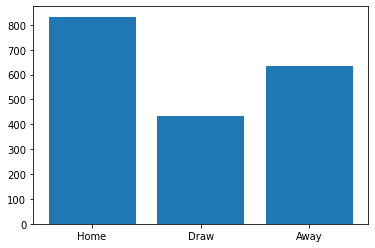

In [5]:
# Explorando a base de dados de dos campeonatos de 2017/2018 a 2021/2022 (últimas 5 temporadas completas)

matches = data.shape[0]
features = data.shape[1]

home_win = len(data[data.FTR==1])
away_win = len(data[data.FTR==2])
draw = len(data[data.FTR==0])
val = [home_win, draw, away_win]

win_rate = (float(home_win)/(matches)) *100

print ('Total de jogos: ', matches)
print ('Total de colunas: ', features)
print ('Total de jogos ganhos em casa: ', home_win)
print ('Total de jogos ganhos pelo visitante: ', away_win)
print ('Total de jogos empatados: ', draw)
print ('Percentual de jogos ganhos em casa: {:.2f}%'.format( win_rate ))

x = np.arange(3)
plt.bar(x, val)
plt.xticks(x, ('Home', 'Draw', 'Away'))
plt.show()

In [6]:
# Separando as features e as labels

features = data[['B365H', 'B365D', 'B365A', 'BWH', 'BWD', 'BWA', 'IWH', 'IWD', 'IWA', 'PSH', 'PSD', 'PSA', 'VCH', 'VCD', 'VCA', 'WHH', 'WHD', 'WHA']]
labels = data['FTR']

print('Features')
print(features.head())
print('=====================')
print('Labels')
print(labels.head())

Features
   B365H  B365D  B365A    BWH   BWD    BWA   IWH  IWD    IWA    PSH   PSD  \
0   1.53    4.5   6.50   1.50  4.60   6.75  1.47  4.5   6.50   1.53  4.55   
1  11.00    5.5   1.33  11.00  5.25   1.30  8.00  5.3   1.35  10.95  5.55   
2   1.25    6.5  15.00   1.22  6.50  12.50  1.22  6.2  13.50   1.26  6.30   
3   1.83    3.6   5.00   1.80  3.50   4.75  1.85  3.5   4.30   1.83  3.58   
4   1.70    3.8   5.75   1.70  3.60   5.50  1.70  3.7   5.00   1.70  3.83   

     PSA    VCH   VCD    VCA    WHH  WHD    WHA  
0   6.85   1.53  4.50   6.50   1.53  4.2   6.00  
1   1.34  10.00  5.50   1.33  10.00  4.8   1.33  
2  15.25   1.25  6.25  15.00   1.25  5.5  13.00  
3   5.11   1.83  3.60   5.00   1.80  3.3   5.00  
4   5.81   1.70  3.80   5.75   1.70  3.5   5.50  
Labels
0    1
1    2
2    2
3    2
4    1
Name: FTR, dtype: int32


In [7]:
# Normalizando os dados de entrada (features)

scaler = MinMaxScaler().fit(features)
features_scale = scaler.transform(features)

print('Features: ',features_scale.shape)
print(features_scale)

Features:  (1900, 18)
[[0.02142206 0.11971831 0.13490471 ... 0.02406015 0.10743802 0.1087344 ]
 [0.45305378 0.19014085 0.0052658  ... 0.44862155 0.15702479 0.00467914]
 [0.00865998 0.26056338 0.34804413 ... 0.01002506 0.21487603 0.26470588]
 ...
 [0.00364631 0.40140845 0.34804413 ... 0.00501253 0.33884298 0.39839572]
 [0.00455789 0.36619718 0.39819458 ... 0.00501253 0.33884298 0.39839572]
 [0.38468551 0.26056338 0.00325978 ... 0.44862155 0.25619835 0.00289661]]


In [8]:
# Separação de treino e teste, feita manualmente para manter a ordem cronológica, uma vez que...
# ... temos informação temporal.
# Treino [:1520]     representa 80% dos dados
# Teste [1520:1710]      representa 10% dos dados
# Previsão [1710:1900]     representa 10% dos dados


X_train = features_scale[:1520]
X_test = features_scale[1520:1710]
y_train = labels[:1520]
y_test = labels[1520:1710]

print(len(X_train), len(y_train))
print(len(X_test), len(y_test))

1520 1520
190 190


In [9]:
# Rodando o modelo de Regressão Logística em sua versão multinomial

clf_LR = LogisticRegression(multi_class = 'multinomial', max_iter = 2000)
clf_LR.fit(X_train, y_train)
pred = clf_LR.predict(X_test)

lr_acc = accuracy_score(y_test, pred)
f1 = f1_score(y_test, pred, average = 'micro')

print('Regressão Logística')
print('')
print('Acurácia: {:.2f}%'.format(lr_acc*100))
print('F1 Score: {:.2f}%'.format(f1*100))

Regressão Logística

Acurácia: 56.32%
F1 Score: 56.32%


In [10]:
# Rodando o modelo de Support Vector Machine (SVM)

clf_SVM = SVC()
clf_SVM.fit(X_train, y_train)
pred = clf_SVM.predict(X_test)

svm_acc = accuracy_score(y_test, pred)
f1 = f1_score(y_test, pred, average = 'micro')

print('SVM')
print('')
print('Acurácia: {:.2f}%'.format(svm_acc*100))
print('F1 Score: {:.2f}%'.format(f1*100))

SVM

Acurácia: 56.32%
F1 Score: 56.32%


In [11]:
# Rodando o modelo de Árvore de Decisão

clf_DT = DecisionTreeClassifier(random_state=42)
clf_DT.fit(X_train, y_train)
pred = clf_DT.predict(X_test)

dt_acc = accuracy_score(y_test, pred)
f1 = f1_score(y_test, pred, average = 'macro')

print('Árvore de Decisão')
print('')
print('Acurácia: {:.2f}%'.format(dt_acc*100))
print('F1 Score: {:.2f}%'.format(f1*100))

Árvore de Decisão

Acurácia: 43.68%
F1 Score: 42.29%


In [12]:
# Rodando o modelo de Naive Bayes

clf_NB = GaussianNB()
clf_NB.fit(X_train, y_train)
pred = clf_NB.predict(X_test)

nb_acc = accuracy_score(y_test, pred)
f1 = f1_score(y_test, pred, average = 'micro')

print('Naive Bayes')
print('')
print('Acurácia Naive Bayes: {:.2f}%'.format(nb_acc*100))
print('F1 Score: {:.2f}%'.format(f1*100))

Naive Bayes

Acurácia Naive Bayes: 47.89%
F1 Score: 47.89%


In [13]:
#Executando a previsão pelo método de maior acurácia (Regressão Logística)

previsao = features_scale[1710:]

game_id_full = data['Game_id']
game_id_prev = game_id_full[1710:]

res_full = data['FTR']
res_prev = res_full[1710:]

pred = clf_LR.predict(previsao)

df = pd.DataFrame({'Real': res_prev, 'Previsão': pred, 'Game_id': game_id_prev})

print(df)

      Real  Previsão  Game_id
1710     2         1     1711
1711     1         1     1712
1712     1         1     1713
1713     0         1     1714
1714     1         1     1715
...    ...       ...      ...
1895     1         2     1896
1896     1         1     1897
1897     1         1     1898
1898     1         1     1899
1899     2         2     1900

[190 rows x 3 columns]


<AxesSubplot:xlabel='Previsão', ylabel='Real'>

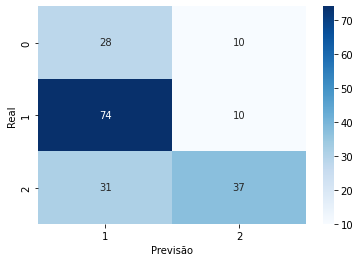

In [14]:
#confusion Matrix

df = pd.DataFrame(df,columns = ['Real','Previsão'])

cf_matrix = pd.crosstab(df['Real'], df['Previsão'], rownames = ['Real'] , colnames = ['Previsão'])

sns.heatmap(cf_matrix, annot = True, cmap = 'Blues', fmt = 'g')